##  Kaplan-Meier Curve Analysis
● Generate Kaplan-Meier survival curves for at least two distinct groups (e.g., treatment
type, age group, or tumor stage), ensuring each group has its own plot.
● For each plot, conduct a log-rank test to compare survival differences between the
groups.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
import lifelines.statistics
from sksurv.util import Surv
from datetime import datetime
from lifelines.statistics import logrank_test
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

In [2]:
data = pd.read_excel('C:/GitHub/BINF-5507-Assignments/Assignment-4/Data/RADCURE_Clinical_v04_20241219.xlsx')

#data.head()
data.describe()
data.info()
print(data.shape)
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

In [3]:
# Data Cleaning
data.isnull().sum()  # Check for missing values

# Remove columns with more than 20% missing values
threshold = 0.2  
missing_percent = data.isnull().mean()
cols_to_drop = missing_percent[missing_percent > threshold].index
clean_data = data.drop(columns=cols_to_drop)

# Impute missing values for the rest of the data
# Fill numerical columns with mean and categorical columns with mode
num_cols = clean_data.select_dtypes(include='number').columns
clean_data[num_cols] = clean_data[num_cols].fillna(clean_data[num_cols].mean())

cat_cols = clean_data.select_dtypes(include='object').columns
for col in cat_cols:
    clean_data[col] = clean_data[col].fillna(clean_data[col].mode().iloc[0])

# Convert categorical columns to numerical using one-hot encoding
#clean_data = pd.get_dummies(clean_data, columns=cat_cols, drop_first=True)


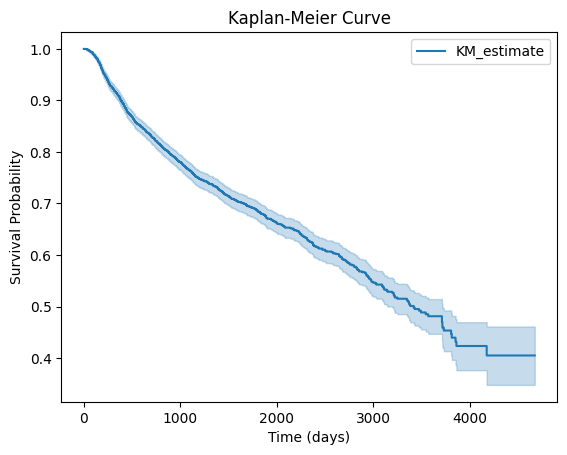

In [4]:
clinical_data = clean_data.copy()

# Convert Status column to boolean (Dead = True, Alive = False)
clinical_data["event"] = clinical_data["Status"].apply(lambda x: True if x == "Dead" else False)

# # Calculate time in days
clinical_data["time"] = (clinical_data["Last FU"] - clinical_data["RT Start"]).dt.days

# Convert event column to boolean (Dead = True, Alive = False)
clinical_data["event"] = clinical_data["Status"].apply(lambda x: True if x == "Dead" else False)

# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(clinical_data['time'], event_observed=clinical_data['event'])

# Plot the Kaplan-Meier curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()


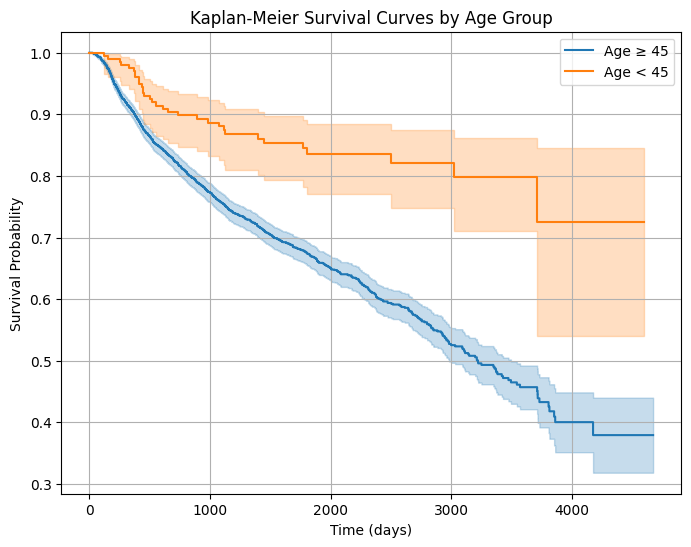

In [32]:
clinical_data["Age"].value_counts()

## Instantiate the class to create an object

## creating 2 cohorts : with at least one positive axillary detected, and one with no one detected
groups_1 = clinical_data['Age']  
clinical_data["group"] = clinical_data["Age"].apply(lambda x: 1 if x >= 45 else 2) 

df = clinical_data
T_1 = df[df["group"] == 1]["time"]
E_1 = df[df["group"] == 1]["event"]
T_2 = df[df["group"] == 2]["time"]
E_2 = df[df["group"] == 2]["event"]

km_age1 = KaplanMeierFitter(label="Age ≥ 45").fit(T_1, E_1)
km_age2 = KaplanMeierFitter(label="Age < 45").fit(T_2, E_2)


plt.figure(figsize=(8,6))
km_age1.plot_survival_function()
km_age2.plot_survival_function()
plt.title("Kaplan-Meier Survival Curves by Age Group")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

# Convert to sksurv structured array format
# survival_data = Surv.from_dataframe("event", "time", clinical_data)

# Log rank test

In [ ]:
#lifelines.statistics.logrank_test('time', 'event').p_value
results = logrank_test(T_1, T_2, E_1,E_2)

# Print the result
results.print_summary()
print("Log-rank p-value:", results.p_value)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          30.15 <0.005     24.57

Log-rank p-value: 4.005058362200854e-08


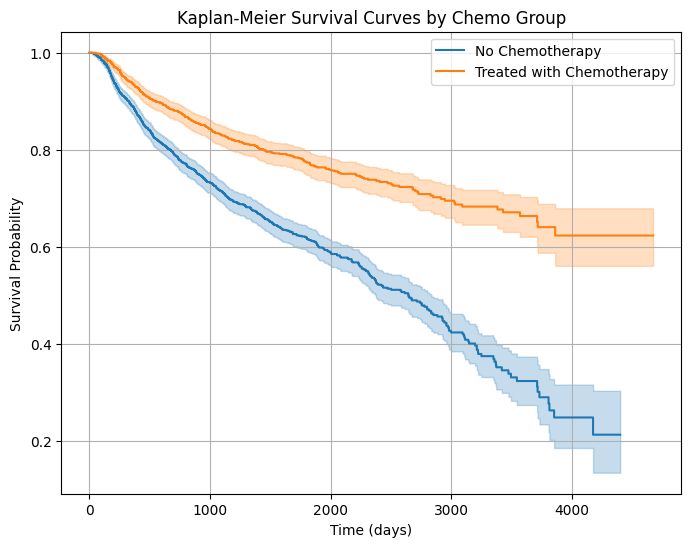

In [ ]:

clinical_data["Chemo"].value_counts()

## creating 2 cohorts : with at least one positive axillary detected, and one with no one detected
groups_2 = clinical_data["Chemo"]  
clinical_data["group"] = clinical_data["Chemo"].apply(lambda x: 1 if x == 'none' else 2)

df = clinical_data
T1 = df[df["group"] == 1]["time"]
E1 = df[df["group"] == 1]["event"]
T2 = df[df["group"] == 2]["time"]
E2 = df[df["group"] == 2]["event"]

km_chemo1 = KaplanMeierFitter(label="No Chemotherapy").fit(T1, E1)
km_chemo2 = KaplanMeierFitter(label="Treated with Chemotherapy").fit(T2, E2)

plt.figure(figsize=(8,6))
km_chemo1.plot_survival_function()
km_chemo2.plot_survival_function()
plt.title("Kaplan-Meier Survival Curves by Chemo Group")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

## Log rank test


In [ ]:
#lifelines.statistics.logrank_test('time', 'event').p_value
results2 = logrank_test(T1, T2,E1,E2)

# Print the result
results2.print_summary()
print("Log-rank p-value:", results2.p_value)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         124.19 <0.005     93.40

Log-rank p-value: 7.672624957190955e-29


In [ ]:
# Define which stages are considered advanced
advanced_stages = ["III", "IIIA", "IIIB", "IV", "IVA", "IVB"]

# Create the binary group
clinical_data["stage_group"] = clinical_data["Stage"].astype(str).isin(advanced_stages)

group1 = clinical_data[clinical_data["stage_group"] == True]
group2 = clinical_data[clinical_data["stage_group"] == False]

results_stage = logrank_test(
    group1["Age"], group2["Age"],
    event_observed_A=group1["event"],
    event_observed_B=group2["event"]
)

print("Stage group log-rank p-value:", results_stage.p_value)

In [ ]:
print(clinical_data.dtypes)

In [29]:
clinical_data["Stage"].unique()

array(['IVB', 'I', 'IVA', 'III', 'II', nan, 'IV', 0, 'IIIC', 'IB', 'X',
       'IIA', 'IIIA', 'IVC', 'IIB'], dtype=object)

2. Cox Proportional Hazards Regression

● Perform a Cox regression analysis, including at least three covariates.

● Validate the proportional hazards assumption.

<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7923.11
         time fit was run = 2025-07-15 05:54:25 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
stage_IV                  0.99      2.70      0.38            0.25            1.73                1.28                5.67
smoking_status_Ex-smoker -0.02      0.98      0.05           -0.13            0.09                0.88                1.09
chemo_none                0.54      1.72      0.06            0.43            0.65                1.54                1.92

                          cmp to     z      p  -log2(p)
covariate                                              
stage_IV                    0.00  2.62   0.01      6.82
smoking_status_Ex-smoker    0.00 -0.34   0.73      0.45
chemo_none                  0.00  9.66 <0.005     70.88
---
Concordance = 0.58
Partial AIC = 15852.22
log-likelihood ratio test = 101.61 on 3 df
-log2(p) of ll-ratio test = 70.27

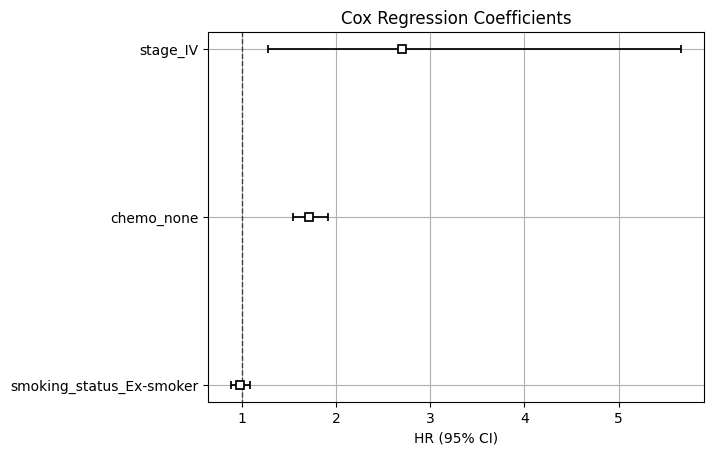

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
chemo_none               km              7.02 0.01      6.95
                         rank            4.35 0.04      4.76
smoking_status_Ex-smoker km              4.08 0.04      4.53
                         rank            2.44 0.12      3.08
stage_IV                 km              0.43 0.51      0.97
                         rank            0.87 0.35      1.51



1. Variable 'chemo_none' failed the non-proportional test: p-value is 0.0081.

   Advice: with so few unique values (only 2), you can include `strata=['chemo_none', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

In [ ]:
data_cph = clinical_data[['age', 'sex', 'ecog_ps','smoking_py', 'smoking_status', 'ds_site', 't', 'n', 'm', 'stage', 'path', 'tx_modality', 'chemo', 'dose', 'fx', 'length_fu', 'event', 'time']]
data_cph.isnull().sum()

data_cph = data_cph.dropna(subset=data_cph.columns)
data_cph["sex"] = data_cph["sex"].astype("category")
# Step 1: Identify categorical columns
cat_cols = data_cph.select_dtypes(include=["object", "category"]).columns.tolist()

# Step 2: One-hot encode them
#data_cph_encoded = pd.get_dummies(data_cph, columns=cat_cols, drop_first=True)
encoded_data = pd.get_dummies(data_cph, drop_first=True)

# Drop constant columns
encoded_data = encoded_data.loc[:, encoded_data.nunique() > 1]

# Drop perfectly correlated columns
corr_matrix = encoded_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
encoded_data.drop(columns=to_drop, inplace=True)
encoded_data["time"] = data_cph["time"]
encoded_data["event"] = data_cph["event"]

selected_covariates = ["stage_IV", "smoking_status_Ex-smoker", "chemo_none", "time", "event"]
data_subset = encoded_data[selected_covariates]
cph = CoxPHFitter(penalizer=0.1)
cph.fit(data_subset, 'time', event_col='event')
cph.print_summary()

cph.plot(hazard_ratios=True)
plt.title("Cox Regression Coefficients")
plt.grid(True)
plt.show()

# Validate proportional hazards assumption
cph.check_assumptions(data_subset)

3. Random Survival Forests (RSF)

● Build a Random Survival Forest model to predict survival.

● Perform variable importance analysis to identify the most predictive factors.

● Compare the model’s concordance index (C-index) with that of Cox regression.

In [57]:
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Create structured survival array
data_y = Surv.from_dataframe("event", "time", clinical_data)

# Prepare feature matrix
data_x = clinical_data.drop(columns=["event", "time"])
data_x = data_x.select_dtypes(exclude=["datetime64[ns]"])

# Identify categorical columns
cat_cols = data_x.select_dtypes(include=["object", "string"]).columns

# Convert them to 'category' dtype
for col in cat_cols:
    data_x[col] = data_x[col].astype("category")

# One-hot encode categorical variables
encoder = OneHotEncoder()
data_x_encoded = encoder.fit_transform(data_x)
data_x_encoded = pd.DataFrame(data_x_encoded, columns=encoder.get_feature_names_out())


# Train RSF model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(data_x_encoded, data_y)

# Permutation importance
result = permutation_importance(rsf, data_x_encoded, data_y, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame({
    "importances_mean": result["importances_mean"],
    "importances_std": result["importances_std"]
}, index=data_x_encoded.columns).sort_values(by="importances_mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(
    feature_importance.index,
    feature_importance["importances_mean"],
    xerr=feature_importance["importances_std"],
    align="center"
)
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

# Convert to sksurv structured array format
survival_data = Surv.from_dataframe("event", "time", clinical_data)

data_x = clinical_data.drop(columns=["event", "time"])
data_y = survival_data

# Encode categorical variables
# Convert all object/string columns to category
for col in data_x.select_dtypes(include=["object", "string"]).columns:
    data_x[col] = data_x[col].astype("category")
encoder = OneHotEncoder()
data_x = encoder.fit_transform(data_x)

print(clinical_data.columns.tolist())

# Drop the original datetime columns
clinical_data.drop(columns=["RT Start", "Last FU"], inplace=True, errors="ignore")
data_x.drop(columns=["RT Start", "Last FU"], inplace=True, errors="ignore")

print(clinical_data.select_dtypes(include=["datetime64"]).columns)
print(data_x.select_dtypes(include=["datetime64"]).columns)
# mixed_array = np.array([clinical_data["rt_start"].iloc[0], clinical_data["dose"].iloc[0]], dtype=object)

# Train a Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(data_x, data_y)

# Compute permutation importance
result = permutation_importance(rsf, data_x, data_y, n_repeats=15, random_state=42)

# Build feature importance DataFrame
feature_names = encoder.get_feature_names_out()
feature_importance = pd.DataFrame(
    {
        "importances_mean": result["importances_mean"],
        "importances_std": result["importances_std"],
    },
    index=feature_names,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
# feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'Tx Modality', 'Chemo', 'Dose', 'Fx', 'Status', 'Length FU', 'RADCURE-challenge', 'ContrastEnhanced', 'event', 'time']
Index([], dtype='object')
Index([], dtype='object')
